### Введение
С развитием LLM-моделей спрашивать теоретическую часть или короткие алгоритмы и принципы стало бесполезно, поэтому задание будет одно, но комплексное и приближенное к реальности.

Вы можете использовать любые LLM-модели и Copilot для написания кода, так как в реальной работе сотрудники отдела также имеют доступ ко всем современным инструментам (Sonnet 3.5, GPT-4o, GitHub Copilot и т. п.).

В задании вы будете работать с тестовыми данными по банкоматам и API ЦБ РФ для получения ключевой ставки.

---

### Специфика данных fees
`fees` — тарифы за обслуживание банкомата инкассаторами. Так как банкоматы могут находиться в разных регионах, тарифы у них могут отличаться.

- **CashDeliveryFixedFee** — фиксированная стоимость доставки наличных (не зависит от суммы).
- **CashDeliveryPercentageFee** — процент от суммы доставленных наличных. Он добавляется к фиксированной стоимости. Если в таблице указано `0.0001`, это значит 0.01% от суммы.
- **CashDeliveryMinFee** — минимальная сумма, которую с нас возьмут по `CashDeliveryPercentageFee`. Например, если мы попросим инкассаторов в ATM_4 довезти всего 10 000 рублей, то с нас возьмут 5250 рублей (фиксированная стоимость), а так как `10 000 * 0.04% < 450 рублей`, то дополнительно возьмут ещё 450 рублей. Итог: 5250 + 450 рублей.

**CashCollection** — это пример сложного тарифа, который учитывает специфику работы с банкоматом. В банкомат деньги не докладывают, а меняют сразу кассету. Есть провайдеры, которые тарифицируют не только доставку, но и пересчёт денег в извлечённой кассете. Например, в ATM_4 у нас именно такой тариф.  
Пример: у нас в банкомате осталось 500 тыс. рублей, а мы хотим, чтобы у него был баланс 2 млн. Тогда мы заказываем довезти кассету на 2 млн. и платим по тарифу за доставку. При доставке старая кассета извлекается, и мы также по тарифу платим за пересчёт 500 тыс. рублей (0.45%, но не менее 1140 рублей).

- **CashCollectionFixedFee** — фиксированная стоимость за извлечение старой кассеты (в данных примерах нулевая).
- **CashCollectionPercentageFee** — процент от суммы извлечённой кассеты.
- **CashCollectionMinFee** — минимальная сумма, которую с нас возьмут по `CashCollectionPercentageFee`.

---

### Специфика данных transactions
Таблица содержит данные по снятиям, пополнениям (инкассациям) и балансу банкомата на конец дня.  
Считаем, что банкоматы в начале года пустые и не работали, поэтому баланс на конец дня равен 0, пока не случится первая инкассация.

- **bal_end_of_day** — баланс на конец дня.
- **cash_in** — пополнение в результате инкассации.
- **cash_out** — снятие наличных клиентами.

---

In [1]:
import pandas as pd

# Забираем данные по тарфиам на обслуживание банкоматов
fees = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/fees.parquet')
# статистика операция по дням.
transactions = pd.read_parquet('https://storage.yandexcloud.net/norvpublic/transactions.parquet')

### Часть 1 — упущенный процентный доход

Специалисту по ML важно уметь получать данные с различных API и читать документацию. Для расчёта упущенного процентного дохода нужно обратиться к API ЦБ РФ и получить динамику ключевой ставки за 2024 год.

https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?op=KeyRate

Для запроса к API не нужен токен и регистрация. ЦБ РФ для части данных предпочитает использовать SOAP.

Учитывая, что хранить наличные деньги в банкомате — не самое удачное инвестиционное решение, посчитайте упущенный процентный доход для каждого банкомата. Рассчитываем, что банк мог бы вложить эти деньги и получить доход, равный ключевой ставке ЦБ РФ, актуальной на день баланса банкомата. Добавьте к таблице `transactions` столбец с упущенной процентной выгодой.


In [2]:
fees.head()

,ATM_ID,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee
0,ATM_1,1365.0,0.0001,NaN,NaN,NaN,NaN
1,ATM_2,1365.0,0.0001,NaN,NaN,NaN,NaN
2,ATM_4,5250.0,0.0004,450.0,0.0,0.0045,1140.0
3,ATM_3,2250.0,0.0001,675.0,NaN,NaN,NaN


In [3]:
transactions.head()

,date,ATM_ID,bal_end_of_day,cash_in,cash_out
0,2024-01-12 00:00:00+00:00,ATM_1,0.0,0.0,0.0
1,2024-01-12 00:00:00+00:00,ATM_2,0.0,0.0,0.0
2,2024-01-12 00:00:00+00:00,ATM_3,0.0,0.0,0.0
3,2024-01-12 00:00:00+00:00,ATM_4,0.0,0.0,0.0
4,2024-01-13 00:00:00+00:00,ATM_1,0.0,0.0,0.0


In [4]:
import requests
from bs4 import BeautifulSoup

In [5]:
url = "https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx"

soap_request = """
<soap:Envelope xmlns:soap="http://schemas.xmlsoap.org/soap/envelope/" xmlns:web="http://web.cbr.ru/">
    <soap:Body>
        <web:KeyRate>
            <web:fromDate>2024-01-01</web:fromDate>
            <web:ToDate>2024-12-31</web:ToDate>
        </web:KeyRate>
    </soap:Body>
</soap:Envelope>
"""

headers = {
    "Content-Type": "text/xml; charset=utf-8",
    "SOAPAction": "http://web.cbr.ru/KeyRate"
}

response = requests.post(url, data=soap_request, headers=headers)

In [6]:
soup = BeautifulSoup(response.content, "xml")

key_rate_records = soup.find("KeyRate").find_all("KR")

key_rate_data = []
for record in key_rate_records:
    date = record.find("DT").text
    rate = float(record.find("Rate").text)
    key_rate_data.append({"date": pd.to_datetime(date), "rate": rate})

key_rate_df = pd.DataFrame(key_rate_data)

In [7]:
key_rate_df.head()

,date,rate
0,2024-12-18 00:00:00+03:00,21.0
1,2024-12-17 00:00:00+03:00,21.0
2,2024-12-16 00:00:00+03:00,21.0
3,2024-12-13 00:00:00+03:00,21.0
4,2024-12-12 00:00:00+03:00,21.0


In [8]:
key_rate_df["date_only"] = key_rate_df["date"].dt.date
transactions["date_only"] = transactions["date"].dt.date

In [9]:
transactions = transactions.merge(key_rate_df, on="date_only", how="left")
transactions.drop(columns=["date_only", "date_y"], inplace=True)
transactions.rename(columns={"date_x": "date"}, inplace=True)

In [10]:
transactions[transactions["rate"].isna()]

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,rate
4,2024-01-13 00:00:00+00:00,ATM_1,0.0,0.0,0.0,NaN
5,2024-01-13 00:00:00+00:00,ATM_2,0.0,0.0,0.0,NaN
6,2024-01-13 00:00:00+00:00,ATM_3,0.0,0.0,0.0,NaN
7,2024-01-13 00:00:00+00:00,ATM_4,0.0,0.0,0.0,NaN
8,2024-01-14 00:00:00+00:00,ATM_1,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...
1155,2024-10-26 00:00:00+00:00,ATM_4,752650.0,0.0,0.0,NaN
1156,2024-10-27 00:00:00+00:00,ATM_1,4311200.0,0.0,4000.0,NaN
1157,2024-10-27 00:00:00+00:00,ATM_2,5924000.0,0.0,0.0,NaN
1158,2024-10-27 00:00:00+00:00,ATM_3,2395400.0,0.0,0.0,NaN


In [11]:
transactions.sort_values(by="date", inplace=True)
transactions["rate"] = transactions["rate"].ffill()
# t_merged["rate"].fillna(method="ffill") - deprecated

Отлично, теперь рассчитаем упущенный процентный доход по следующей формуле:

$$\text{Упущенный процентный доход} = \frac{\text{баланс на конец дня} \times \text{ключевая ставка}}{365 \times 100}$$

Здесь мы делим на 100 из-за того, что в колонке rate указано значение процента, а не десятичная дробь.

In [12]:
transactions["lost_income"] = transactions["bal_end_of_day"] * transactions["rate"] / (365 * 100)

In [13]:
transactions

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,rate,lost_income
0,2024-01-12 00:00:00+00:00,ATM_1,0.0,0.0,0.0,16.0,0.000000
1,2024-01-12 00:00:00+00:00,ATM_2,0.0,0.0,0.0,16.0,0.000000
2,2024-01-12 00:00:00+00:00,ATM_3,0.0,0.0,0.0,16.0,0.000000
3,2024-01-12 00:00:00+00:00,ATM_4,0.0,0.0,0.0,16.0,0.000000
4,2024-01-13 00:00:00+00:00,ATM_1,0.0,0.0,0.0,16.0,0.000000
...,...,...,...,...,...,...,...
1169,2024-10-30 00:00:00+00:00,ATM_2,5149700.0,0.0,580000.0,21.0,2962.841096
1173,2024-10-31 00:00:00+00:00,ATM_2,4754600.0,0.0,395100.0,21.0,2735.523288
1174,2024-10-31 00:00:00+00:00,ATM_3,2277000.0,0.0,1000.0,21.0,1310.054795
1172,2024-10-31 00:00:00+00:00,ATM_1,3215500.0,0.0,171600.0,21.0,1850.013699


### Часть 2 - расходы на инкассацию

Теперь к данным по банкоматам, кроме упущенного процентного дохода, необходимо добавить столбец расходов на инкассацию. Для простоты считаем, что мы не платим за аренду помещения и страхование, поэтому нам достаточно данных по тарифам на инкассацию (`fees`).

In [14]:
transactions = transactions.merge(fees, on="ATM_ID", how="left")

In [15]:
transactions.sort_values(by=["ATM_ID", "date"], inplace=True) 
transactions["prev_bal_end_of_day"] = transactions.groupby("ATM_ID")["bal_end_of_day"].shift(1)

In [16]:
transactions.isna().sum()

date                             0
ATM_ID                           0
bal_end_of_day                   0
cash_in                          0
cash_out                         0
rate                             0
lost_income                      0
CashDeliveryFixedFee             0
CashDeliveryPercentageFee        0
CashDeliveryMinFee             588
CashCollectionFixedFee         882
CashCollectionPercentageFee    882
CashCollectionMinFee           882
prev_bal_end_of_day              4
dtype: int64

In [17]:
transactions.fillna(0, inplace=True)

In [18]:
transactions["delivery_costs"] = transactions.apply(
    lambda row: (
        row["CashDeliveryFixedFee"] +
        max(row["CashDeliveryMinFee"], row["CashDeliveryPercentageFee"] * row["cash_in"])
    ) if row["cash_in"] > 0 else 0,
    axis=1
)

transactions["collection_costs"] = transactions.apply(
    lambda row: (
        row["CashCollectionFixedFee"] +
        max(row["CashCollectionMinFee"], row["CashCollectionPercentageFee"] * row["prev_bal_end_of_day"])
    ) if row["prev_bal_end_of_day"] > 0 else 0,
    axis=1
)

transactions["costs"] = transactions["delivery_costs"] + transactions["collection_costs"]

# transactions.drop(columns=["CashDeliveryFixedFee", "CashDeliveryPercentageFee", "CashDeliveryMinFee", "CashCollectionFixedFee", 
#                            "CashCollectionPercentageFee", "CashCollectionMinFee", "delivery_costs", "collection_costs"], inplace=True)

In [19]:
transactions

,date,ATM_ID,bal_end_of_day,cash_in,cash_out,rate,lost_income,CashDeliveryFixedFee,CashDeliveryPercentageFee,CashDeliveryMinFee,CashCollectionFixedFee,CashCollectionPercentageFee,CashCollectionMinFee,prev_bal_end_of_day,delivery_costs,collection_costs,costs
0,2024-01-12 00:00:00+00:00,ATM_1,0.0,0.0,0.0,16.0,0.000000,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,0.0,0.000,0.000
4,2024-01-13 00:00:00+00:00,ATM_1,0.0,0.0,0.0,16.0,0.000000,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,0.0,0.000,0.000
10,2024-01-14 00:00:00+00:00,ATM_1,0.0,0.0,0.0,16.0,0.000000,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,0.0,0.000,0.000
13,2024-01-15 00:00:00+00:00,ATM_1,0.0,0.0,0.0,16.0,0.000000,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,0.0,0.000,0.000
18,2024-01-16 00:00:00+00:00,ATM_1,0.0,0.0,0.0,16.0,0.000000,1365.0,0.0001,0.0,0.0,0.0000,0.0,0.0,0.0,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,2024-10-27 00:00:00+00:00,ATM_4,752650.0,0.0,0.0,19.0,391.790411,5250.0,0.0004,450.0,0.0,0.0045,1140.0,752650.0,0.0,3386.925,3386.925
1163,2024-10-28 00:00:00+00:00,ATM_4,752650.0,0.0,0.0,21.0,433.031507,5250.0,0.0004,450.0,0.0,0.0045,1140.0,752650.0,0.0,3386.925,3386.925
1165,2024-10-29 00:00:00+00:00,ATM_4,748650.0,0.0,4000.0,21.0,430.730137,5250.0,0.0004,450.0,0.0,0.0045,1140.0,752650.0,0.0,3386.925,3386.925
1169,2024-10-30 00:00:00+00:00,ATM_4,747650.0,0.0,1000.0,21.0,430.154795,5250.0,0.0004,450.0,0.0,0.0045,1140.0,748650.0,0.0,3368.925,3368.925


### Часть 3 - анализ данных

Посмотрите на данные о снятиях, инкассациях и балансе. В данных подобраны банкоматы, отличающиеся по характеру использования и частоте инкассаций.  
(Эту операцию вы делаете для себя, чтобы лучше понять специфику.)

In [20]:
import matplotlib.pyplot as plt

In [21]:
transactions_summary = transactions.groupby("ATM_ID")[["bal_end_of_day", "cash_in", "cash_out"]].describe()
transactions_summary

bal_end_of_day                                                         \
                count          mean           std  min        25%        50%   
ATM_ID                                                                         
ATM_1           294.0  3.666365e+06  1.767245e+06  0.0  2255975.0  3902900.0   
ATM_2           294.0  3.999686e+06  1.766966e+06  0.0  2705800.0  4074650.0   
ATM_3           294.0  2.776978e+06  1.735360e+06  0.0  1337875.0  2753400.0   
ATM_4           294.0  1.074001e+06  3.691588e+05  0.0   827700.0  1062050.0   

                             cash_in                 ...                  \
              75%        max   count           mean  ...  75%        max   
ATM_ID                                               ...                   
ATM_1   5105750.0  6545500.0   294.0  491292.517007  ...  0.0  6620000.0   
ATM_2   5442150.0  7119900.0   294.0  516122.448980  ...  0.0  7120000.0   
ATM_3   4179225.0  5925000.0   294.0   79455.782313  ...  0.0  5980000.0   
ATM_4   1360900.0  1630000.0   294.0   16632.653061  ...  0.0  1630000.0   

       cash_out                                                         \
          count           mean            std  min       25%       50%   
ATM_ID                                                                   
ATM_1     294.0  390943.877551  344635.680836  0.0  122275.0  316550.0   
ATM_2     294.0  391734.693878  389629.884525  0.0       0.0  320500.0   
ATM_3     294.0   58422.789116   84941.266544  0.0    2050.0   28300.0   
ATM_4     294.0    8677.210884   17250.819075  0.0       0.0       0.0   

                             
             75%        max  
ATM_ID                       
ATM_1   585825.0  1594200.0  
ATM_2   668775.0  1909800.0  
ATM_3    77800.0   623200.0  
ATM_4    10087.5   127250.0  

[4 rows x 24 columns]

Построим графики снятий, инкассаций и балансов у разных банкоматов.

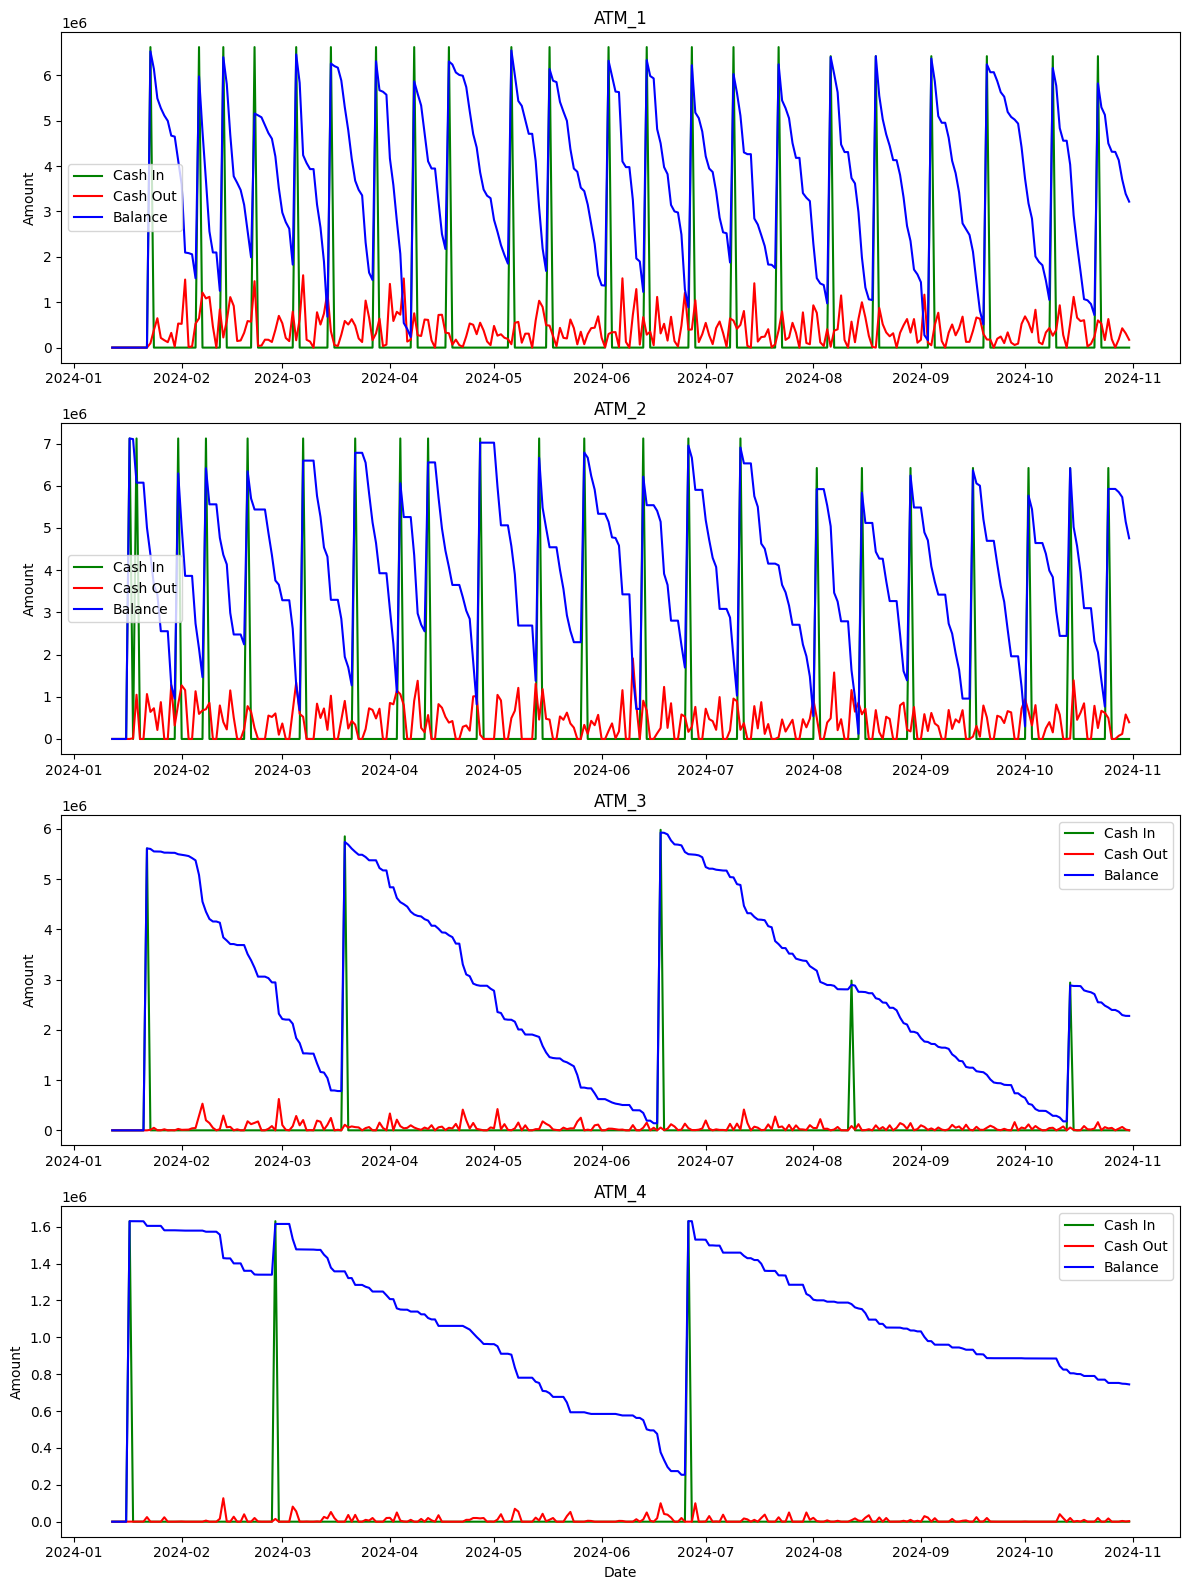

In [22]:
atm_ids = transactions["ATM_ID"].unique()

fig, axes = plt.subplots(len(atm_ids), 1, figsize=(12, 16))
for i, atm_id in enumerate(atm_ids):
    atm_data = transactions[transactions["ATM_ID"] == atm_id]
    axes[i].plot(atm_data["date"], atm_data["cash_in"], label="Cash In", color="green")
    axes[i].plot(atm_data["date"], atm_data["cash_out"], label="Cash Out", color="red")
    axes[i].plot(atm_data["date"], atm_data["bal_end_of_day"], label="Balance", color="blue")
    axes[i].set_title(atm_id)
    axes[i].set_ylabel("Amount")
    axes[i].legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()

**По таблице и графику можем сделать следующие выводы:**
- У ATM_1 и ATM_2 самые крупные балансы и объёмы операций. Средний баланс составляет около 3.5 – 4 млн рублей
- Также у них наблюдаются регулярные и крупные снятия (в среднем около 390 тыс. рублей)
- У АТМ_3 средний баланс значительно ниже - 2.7 млн рублей
- Средние суммы снятий и пополнений тоже не такие большие (58 и 79 тыс рублей соответственно)
- АТМ_4 - наименее активный банкомат, у него наименьшие баланс, снятие и пополнение

**Характер использования данных банкоматов действительно разный:**
- ATM_1 и ATM_2 требуют регулярной инкассации для поддержания баланса
- АТМ_3 и АТМ_4 же, в свою очередь, имеют меньшую активность, что позволяет реже проводить инкассацию

### Часть 4 - меняем бизнес с помощью ML

Заключительная и самая интересная часть. К данному этапу у нас уже рассчитан упущенный процентный доход и расходы на инкассацию. Подумайте, как использовать ваши знания, чтобы оптимизировать процесс инкассации и уменьшить издержки.

Для данной задачи считаем, что нас устроит Service Level на уровне 90%. Это значит, что если в 9 из 10 случаев наши клиенты получают нужные им суммы, нас это устраивает.

Напоминаем, что технически в банкомат нельзя довнести сумму, и кассета меняется полностью. Соответственно, с нас берут оплату за полную кассету (если вдруг решите подойти к задаче через классическую формулу EOQ).

Вы можете подойти к задаче абсолютно любым способом и использовать все возможности ООП, Python и любых библиотек. Всё как в реальной работе, где вас никто не ограничивает.

Эффективность своего решения вы можете показать с помощью ретротестирования. Считаем, что каждая кассета может вмещать абсолютно любые суммы. Чтобы добавить реализма, вы можете считать, что деньги нужно заказывать за 3 дня до их доставки.


In [23]:
import numpy as np
from scipy.stats import norm

In [24]:
def calc_optimal_cash_order(transactions, atm_id):
    atm_data = transactions[transactions["ATM_ID"] == atm_id].copy()
    
    atm_data["predicted_cash_out"] = atm_data["cash_out"].rolling(window=7, min_periods=1).mean()
    atm_data["demand_std"] = atm_data["cash_out"].rolling(window=7, min_periods=1).std()
    atm_data["demand_std"].fillna(0, inplace=True)
    
    # Добавим корректирующий коэффициент и z-оценку, чтобы достичь точного уровня
    z_score = norm.ppf(0.9)
    adjustment_factor = 1.16
    atm_data["safety_stock"] = adjustment_factor * z_score * atm_data["demand_std"]
    
    atm_data["optimal_cash_order"] = atm_data["predicted_cash_out"] + atm_data["safety_stock"]
    atm_data["order_day"] = atm_data["date"] - pd.Timedelta(days=3)
    
    return atm_data

In [25]:
atm_ids = transactions["ATM_ID"].unique()
optimized_transactions = pd.concat([calc_optimal_cash_order(transactions, atm_id) for atm_id in atm_ids])

In [26]:
optimized_transactions["cost_reduction"] = optimized_transactions["costs"] - optimized_transactions["optimal_cash_order"] * optimized_transactions["CashDeliveryPercentageFee"]
total_reduction = optimized_transactions["cost_reduction"].sum()
service_level_achieved = (optimized_transactions["cash_out"] <= optimized_transactions["optimal_cash_order"]).mean()

print(f"Издержки снижены на {total_reduction:.2f} рублей")
print(f"Достигнутый уровень обслуживания: {service_level_achieved * 100:.2f}%")

Издержки снижены на 1478549.20 рублей
Достигнутый уровень обслуживания: 90.05%
